User Based Recommender - Lectures Week 4
======

# User filtered algorithms

* our past tests predict our future
	* we have stable taste
	* our system is scoped within system of agreement - we agree on one thing then we agree on others
* measure of inter-user agreement
	* correlation, vector cosine
* personalised recommendations
	* weighted combinations of other ratings
* we need tweaks to make stuff works
* computation will be an issue
	* correlation of all users O(n)
	* pairwise correlations is O(m^2n)
	* recommendations > O(mn)
	* solutions 
		* persistent neighbourhood (m -> k)
		* cached or incremental correlations

# Basic user breakdown

* prediction for user a using rating r and accounting for diference between users with weight w $p_{a,i} = \frac{\sum_{u=1} ^n r_{u,i} w_{u,i}}{\sum_{u=1} ^n w_{u,i} }$
* another approach is to estimate relative likeness from each user and from there estimate it for each user
	* $p_{a,i} = \frac{\sum_{u=1} ^n (r_{u,i} -\overline{r_u})}{n}$
	* $p_{a,i} = \overline{r_a} + \frac{\sum_{u=1} ^n (r_{u,i} -\overline{r_u})w_{u,i} }{\sum_{u=1} ^n w_{u,i} }$
	* such normalisation has been measured to account for 50% of total accuracy in presonal collaborative filtering
* the best way to calculate weight is to calculate Pearson correlation coefficient
$\frac{cov(X,Y)}{\sigma_X \sigma_Y} = \frac{\sum_{u=1} ^n [(X-\mu X)(Y-\mu X)]}{\sigma_X  \sigma_Y}$
	* problems are when m is mall
	* it will not work with unary data
	* it work best with extremities (we both like/hate this)



# Assignment 3: User-User Collaborative Filtering

Excel file provided has the same table twice, transposed. I will only use movie-row here.

## Read File

In [2]:
from __future__ import division #so I can have float as std and int as //
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import copy

#import pdb #debuggera
%matplotlib inline


from supportFunctions import * #dont forget you CAN'T RELOAD functions

C:\Users\LKB\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [12]:
dataFile = "Assignment3.csv"
print("reading %s" % dataFile)
dfData = pd.read_csv(dataFile, delimiter = ",", error_bad_lines=True, encoding = 'utf-8-sig',na_values = ["NULL",""],header =0,index_col=0);
dfData.head()

reading Assignment3.csv


,MovieName,1648,5136,918,2824,3867,860,3712,2968,3525,...,3556,5261,2492,5062,2486,4942,2267,4809,3853,2288
MovieID,,,,,,,,,,,,,,,,,,,,,
11,Star Wars: Episode IV - A New Hope (1977),NaN,4.5,5.0,4.5,4.0,4.0,NaN,5.0,4.0,...,4,NaN,4.5,4.0,3.5,NaN,NaN,NaN,NaN,NaN
12,Finding Nemo (2003),NaN,5.0,5.0,NaN,4.0,4.0,4.5,4.5,4.0,...,4,NaN,3.5,4.0,2.0,3.5,NaN,NaN,NaN,3.5
13,Forrest Gump (1994),NaN,5.0,4.5,5.0,4.5,4.5,NaN,5.0,4.5,...,4,5.0,3.5,4.5,4.5,4.0,3.5,4.5,3.5,3.5
14,American Beauty (1999),NaN,4.0,NaN,NaN,NaN,NaN,4.5,2.0,3.5,...,4,NaN,3.5,4.5,3.5,4.0,NaN,3.5,NaN,NaN
22,Pirates of the Caribbean: The Curse of the Bl...,4,5.0,3.0,4.5,4.0,2.5,NaN,5.0,3.0,...,3,1.5,4.0,4.0,2.5,3.5,NaN,5.0,NaN,3.5


# Part 1 - Without Normalization

Implement user-user collaborative filtering without normalization.

* Complete the user-by-user correlations matrix
* Identify the top 5 neighbors (the users with the 5 largest, positive correlations) for users 3867 and 89

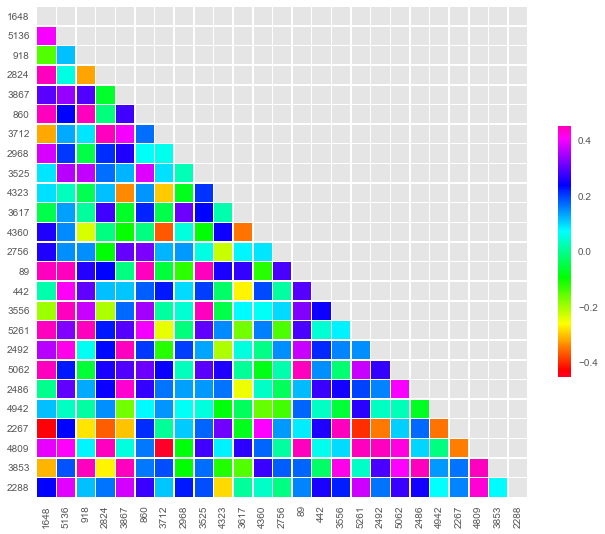

In [13]:
corrMatrix = dfData.corr()
MakeNiceCorrPlot(dfData)
#corrMatrix.columns
user1= corrMatrix.ix['3867',:]
user2= corrMatrix.ix['89',:]

user1 = GetTopFive(user1)
user2 = GetTopFive(user2)


* compute the predictions for each movie for users 3867 and 89 by taking the correlation-weighted average of the ratings of the top-five neighbors (for each target user) for each movie using $p_{a,i} = \frac{\sum_{u=1} ^n r_{u,i} w_{u,i}}{\sum_{u=1} ^n w_{u,i} }$.

for 3712
Top Movie: 641 Prediction: 5.000
2nd Movie: 603 Prediction: 4.856
3rd Movie: 105 Prediction: 4.739
And if the user ID were 3525, there would be a three-way tie among:
Movies: 238, 194, and 38 (all with a prediction of 5.000)

In [51]:
np.array([238, 194, 38])

array([238, 194,  38])

In [56]:
check = GetTopFive(corrMatrix.ix['3525',:])
selectedVotes = dfData.ix[:,check.index.values] #cut to userID
selectedVotes[selectedVotes.index == 238]


,3556,89,860,918,5136
MovieID,,,,,
238,5,5,5,NaN,5


In [70]:
#UserBasedPrediction(user1,dfData)
res = UserBasedPrediction(GetTopFive(corrMatrix.ix['3525',:]),dfData)
res.sort_values(ascending=False, inplace=True)
res.head(5)

MovieID
11       1.902844
12       1.902844
13       1.902844
14       1.902844
22       1.427133
24       2.378555
38       0.000000
63       0.000000
77       0.000000
85       1.902844
98       1.664988
105      1.902844
107      0.000000
114      1.664988
120      1.664988
121      1.427133
122      1.664988
134      2.140699
141      0.000000
146      2.140699
153      1.902844
155      0.000000
161      1.664988
180      1.664988
187      0.000000
194      0.000000
197      1.664988
238      2.378555
243      0.000000
268      1.189277
           ...   
862      2.140699
954      1.189277
955      1.427133
1422     0.000000
1572     1.664988
1597     1.427133
1637     1.427133
1891     1.664988
1892     1.427133
1894     1.902844
1900     1.664988
2024     1.902844
2164     1.427133
2501     1.902844
2502     1.664988
3049     0.000000
4327     0.951422
5503     0.000000
7443     1.427133
8358     1.664988
8467     0.713566
8587     2.378555
9331     0.000000
9741     0.000000
98

MovieID
105    4.676046
13     4.587088
862    4.582405
12     4.467274
603    4.352144
dtype: float64

In [64]:
res.ix[238]

4.1104204219156006

In [69]:
def UserBasedPrediction(CorrSeries,Votes):
  totalWeight = CorrSeries.values.sum()
  predictedVotes = pd.Series(0,index=Votes.index)
  #CorrSeries.values and #CorrSeries.index.values

  #first iterate through corr and relevant userIDs
  for userID,weight in CorrSeries.iteritems():
    #estimate vote from this user, if nan then vote == 0
    predictedVotes = predictedVotes + Votes.ix[:,userID].fillna(value=0)*weight
    print predictedVotes
  predictedVotes = predictedVotes/totalWeight

  return predictedVotes
